<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning/07-Time%20Series%20Forecasting/07_forecasting_using_stateful_rnn_method_using_simple_rnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FORECASTING USINGSTATEFUL RNN METHOD WITH SIMPLE RNN MODEL**

IMPORT LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

USEFUL FUNCTIONS 

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

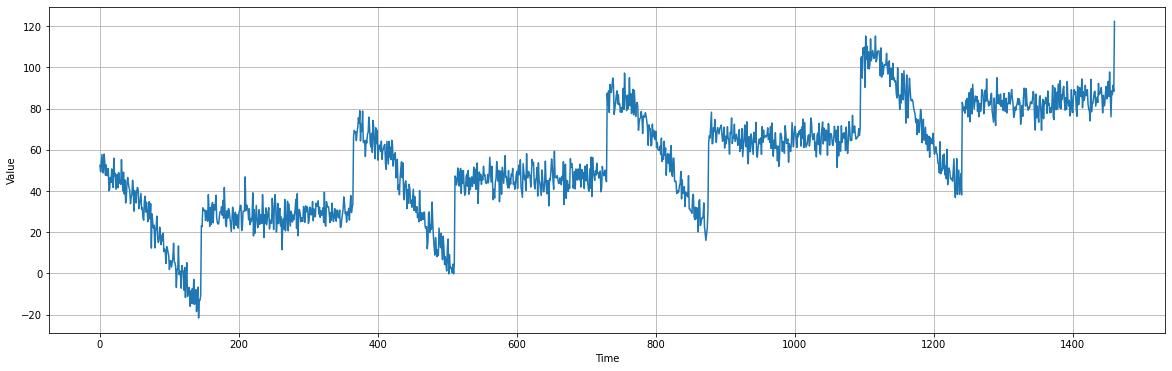

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

In [4]:
## split the dataset to training period and validation period
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
## function to make the window shifting by the window size.
## to do the stateful rnn method.
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [9]:
## example
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print("X :-",X_batch.numpy(), "Y :-", y_batch.numpy())

print(X_batch.shape)
print(y_batch.shape)

X :- [[[0]
  [1]
  [2]]] Y :- [[[1]
  [2]
  [3]]]
X :- [[[3]
  [4]
  [5]]] Y :- [[[4]
  [5]
  [6]]]
X :- [[[6]
  [7]
  [8]]] Y :- [[[7]
  [8]
  [9]]]
(1, 3, 1)
(1, 3, 1)


In [10]:
## defining the class
## this class is used to reset the state at the beginning of the every epochs.
## this class will do that.
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

PREPARE AND RUN THE MODEL

In [12]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 3s 13ms/step - loss: 174.8580 - mae: 175.3580 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 126.7062 - mae: 127.2062 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 67.3729 - mae: 67.8730 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 19.0528 - mae: 19.5433 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 19.4338 - mae: 19.9273 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 17.9321 - mae: 18.4268 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - loss: 17.7708 - mae: 18.2619 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 17.2238 - mae: 17.7169 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 12ms/step - loss: 16.8188 - 

(1e-08, 0.0001, 0.0, 30.0)

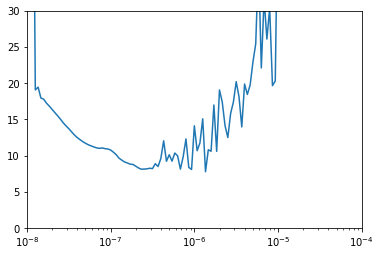

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

The Best Learning Rate could be like 1e-7.

The Model is given below.


In [16]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 3s 31ms/step - loss: 96.3234 - mae: 96.8214 - val_loss: 19.6830 - val_mae: 20.1809
Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 31.1754 - mae: 31.6705 - val_loss: 24.2365 - val_mae: 24.7327
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 23.1072 - mae: 23.5980 - val_loss: 22.5357 - val_mae: 23.0262
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 20.7474 - mae: 21.2396 - val_loss: 19.1602 - val_mae: 19.6580
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 19.8450 - mae: 20.3361 - val_loss: 17.9132 - val_mae: 18.4085
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 19.0318 - mae: 19.5240 - val_loss: 16.5959 - val_mae: 17.0905
Epoch 7/500
33/33 [==============================] - 1s 33ms/step - loss: 18.4047 - mae: 18.8990 - val_loss: 15.3245 - val_mae: 15.8174
Epoch 8/500
33/33 [=============================

In [17]:
model = keras.models.load_model("my_checkpoint.h5")

PREDICTION USING THE MODEL

In [18]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 458ms/step


In [19]:
rnn_forecast.shape

(461,)

PLOTTING THE RESULT

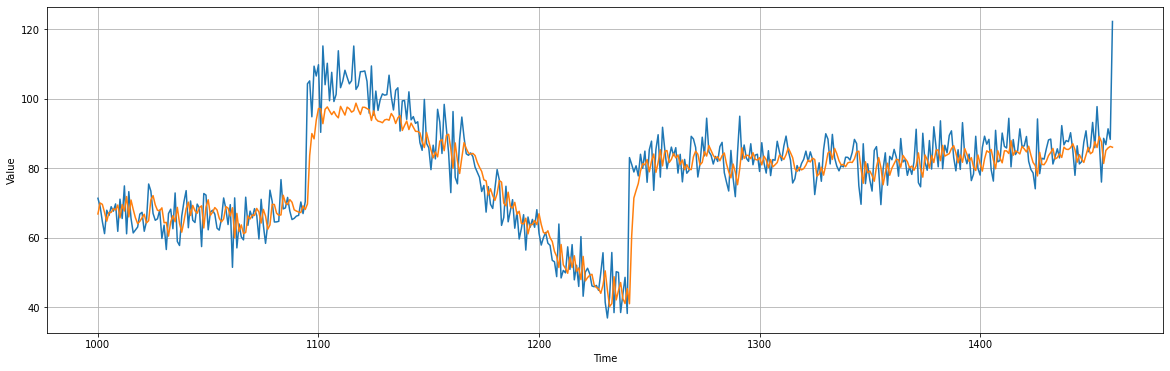

In [20]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
## perfomance score
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.308378

`STATEFUL SEQUENCE TO SEQUENCE SIMPLE RNN MODEL MAE = 5.3`

****